Best number of components: 7


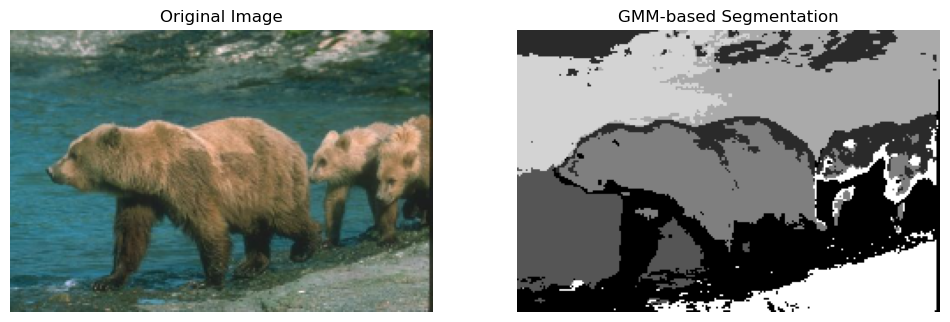

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
import cv2
import urllib.request

# Load the image
image_path = 'image_q2.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Optional: downsample for computational feasibility
scale_percent = 50  # e.g., downsample to 50% of the original size
width = int(image.shape[1] * scale_percent / 100)
height = int(image.shape[0] * scale_percent / 100)
dim = (width, height)
image_resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

# Extract features: row index, column index, and RGB values
rows, cols, _ = image_resized.shape
features = np.zeros((rows * cols, 5))
for r in range(rows):
    for c in range(cols):
        features[r * cols + c, :] = [r / rows, c / cols, 
                                     image_resized[r, c, 0] / 255.0, 
                                     image_resized[r, c, 1] / 255.0, 
                                     image_resized[r, c, 2] / 255.0]

# Fit GMM with 10-fold cross-validation to select the best number of components
kf = KFold(n_splits=10)
best_gmm = None
best_score = -np.inf
best_n_components = 0
possible_n_components = range(2, 21)  # Range of possible components

for n_components in possible_n_components:
    gmm = GaussianMixture(n_components=n_components, covariance_type='full')
    scores = []
    
    for train_idx, val_idx in kf.split(features):
        gmm.fit(features[train_idx])
        score = gmm.score(features[val_idx])
        scores.append(score)
    
    avg_score = np.mean(scores)
    if avg_score > best_score:
        best_score = avg_score
        best_gmm = gmm
        best_n_components = n_components

print(f"Best number of components: {best_n_components}")

# Assign labels to each pixel
labels = best_gmm.predict(features)
label_image = labels.reshape(rows, cols)

# Normalize labels to grayscale values for visualization
label_image_normalized = (255 * (label_image - np.min(label_image)) / 
                          (np.max(label_image) - np.min(label_image))).astype(np.uint8)

# Plot the original and segmented images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image_resized)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(label_image_normalized, cmap='gray')
plt.title("GMM-based Segmentation")
plt.axis('off')

plt.show()